In [1]:
pip install wandb --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.16.3
    Uninstalling wandb-0.16.3:
      Successfully uninstalled wandb-0.16.3
Note: you may need to restart the kernel to use updated packages.


In [2]:
!wandb login 4df0cb3582c248295a7bce45392ae8069917dc61

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import numpy as np
from torch import nn
from torchsummary import summary
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
lr=0.0002
noise_channels=256
img_channels=3
img_size=64
hidden_G=16
hidden_C=16
batch_size=128
epochs=10

In [24]:
from torch.utils.data import DataLoader
import os.path as osp
import glob
def make_datapath_list(root_path):
    """
    Returns:
    -----------
    path_list:list
    保存数据路径的列表
    """
    target_path=osp.join(root_path+'/**/*.jpg')
    
    #使用glob取得文件路径
    return glob.glob(target_path)

root_path='/kaggle/input/celeba'
l=make_datapath_list(root_path)

train_num=int(len(l)*0.8)
train_list=l[:train_num]
test_list=l[train_num:]
len(test_list)


40520

In [25]:
#创建Dataset
from torch.utils import data
import torchvision
from PIL import Image
class CelebDataset(data.Dataset):
    """
    file_path:list
    transform:object
    phase:'train' or 'val'
    """
    def __init__(self,file_list,transform=None,phase='train'):
        self.file_list=file_list
        self.transform=transform
        self.phase=phase
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,index):
        """
        获取预处理完毕的图片的张量数据和标签
        """
        img_path=self.file_list[index]
        img=Image.open(img_path)
        img_tranformed=self.transform(img)
        


        return img_tranformed
    
transform = transforms.Compose([
                               transforms.Resize((img_size,img_size)),
                               transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5))])
train_dataset=CelebDataset(file_list=train_list,transform=transform,phase='train')
test_dataset=CelebDataset(file_list=test_list,transform=transform,phase='test')

index=1
print(train_dataset.__getitem__(index))
print(train_dataset.__getitem__(index)[0].size())


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  0.9922,  0.9922,  0.9922],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.9922,  0.9922,  0.9922],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.9922,  0.9922,  0.9922],
         ...,
         [ 0.2863,  0.2157,  0.3490,  ...,  0.8902,  0.8980,  0.8980],
         [ 0.3490,  0.3333,  0.2863,  ...,  0.8745,  0.8824,  0.8902],
         [ 0.3569,  0.3176,  0.1451,  ...,  0.8824,  0.8824,  0.8902]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.0745, -0.1529, -0.0431,  ...,  0.7647,  0.7647,  0.7647],
         [-0.0353, -0.0588, -0.1373,  ...,  0.7333,  0.7490,  0.7569],
         [-0.0353, -0.0824, -0.2863,  ...,  0.7412,  0.7333,  0.7490]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  0.9529,  0.9529,  0.9529],
         [ 1.0000,  1.0000,  1.0000,  ...,  0

In [26]:
#创建DataLoader
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
dataloaders_dict={
    'train':train_dataloader,
    'test':test_dataloader
}

batch_iter=iter(dataloaders_dict['train'])#转成迭代器
inputs=next(batch_iter)#取第一个元素
print(inputs.size())


torch.Size([128, 3, 64, 64])


In [27]:
class conv_block(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=4,stride=2,padding=1):
        super().__init__()
        self.block=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.block(x)
    
class conv_trans_block(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=4,stride=2,padding=1):
        super().__init__()
        self.block=nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self,x):
        return self.block(x)
    


In [28]:
class Generator(nn.Module):
    def __init__(self,noise_channels,img_channels,hidden_G):
        super().__init__()
        self.G=nn.Sequential(
            conv_trans_block(noise_channels,hidden_G*16,4,1,0),
            conv_trans_block(hidden_G*16,hidden_G*8),
            conv_trans_block(hidden_G*8,hidden_G*4),
            conv_trans_block(hidden_G*4,hidden_G*2),
            nn.ConvTranspose2d(hidden_G*2,img_channels,kernel_size=4,stride=2,padding=1),
            nn.Tanh()
        )
    def forward(self,x):
        return self.G(x)

class Critic(nn.Module):
    def __init__(self, img_channels, hidden_D):
        super(Critic, self).__init__()
        self.D = nn.Sequential(
            conv_block(img_channels, hidden_G),
            conv_block(hidden_G, hidden_G*2),
            conv_block(hidden_G*2, hidden_G*4),
            conv_block(hidden_G*4, hidden_G*8),
            nn.Conv2d(hidden_G*8, 1, kernel_size=4, stride=2, padding=0))

    def forward(self, x):
        return self.D(x)

In [29]:
C=Critic(img_channels,hidden_C).to(device)
G=Generator(noise_channels,img_channels,hidden_G).to(device)

print('Critic :')
summary(C,(img_channels,img_size,img_size))
print('Generator :')
summary(G,(noise_channels,1,1))

opt_C=torch.optim.Adam(C.parameters(),lr=lr, betas=(0.5,0.999))
opt_G=torch.optim.Adam(G.parameters(),lr=lr, betas=(0.5,0.999))

Critic :
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             784
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
        conv_block-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 16, 16]           8,224
       BatchNorm2d-6           [-1, 32, 16, 16]              64
         LeakyReLU-7           [-1, 32, 16, 16]               0
        conv_block-8           [-1, 32, 16, 16]               0
            Conv2d-9             [-1, 64, 8, 8]          32,832
      BatchNorm2d-10             [-1, 64, 8, 8]             128
        LeakyReLU-11             [-1, 64, 8, 8]               0
       conv_block-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 4, 4]         131,200
      BatchNorm2d-14          

In [12]:
import os

try:os.mkdir('latest_model')
except:pass

In [13]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


def get_gradient(crit, real_imgs, fake_imgs, epsilon):

    mixed_imgs = real_imgs * epsilon + fake_imgs*(1 - epsilon)#创建混合图像
    mixed_scores = crit(mixed_imgs)#得到判别分数
    #得到判别器在混合图像上的梯度
    gradient = torch.autograd.grad(outputs=mixed_scores,
                                   inputs=mixed_imgs,
                                   grad_outputs=torch.ones_like(mixed_scores),
                                   create_graph=True,
                                   retain_graph=True)[0]
    return gradient


def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)#L2范数
    #(L2(grad)-1)^2
    penalty = torch.nn.MSELoss()(gradient_norm, torch.ones_like(gradient_norm))
    return penalty


def get_gen_loss(crit_fake_pred):
    gen_loss = -torch.mean(crit_fake_pred)
    return gen_loss


def get_crit_loss(crit_fake_pred, crit_real_pred, gradient_penalty, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - \
        torch.mean(crit_real_pred) + c_lambda * gradient_penalty
    return crit_loss

In [14]:
import wandb
wandb.login()
def save_model_as_checkpoint_wfdb(epoch, model, optimizer, loss, path, run, artifact):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, path)

    artifact.add_file(path)
    run.log_artifact(artifact)

wandb: Currently logged in as: czy_0. Use `wandb login --relogin` to force relogin


In [15]:
name='test1: without_init_weights'
run=wandb.init(project='WGAN_implementation' , name=name)

epoch:1/10 iteration:0/162079 Loss C :1.5391602516174316 -- Loss G :0.31907957792282104
epoch:1/10 iteration:100/162079 Loss C :-191.42990112304688 -- Loss G :93.99201965332031
epoch:1/10 iteration:200/162079 Loss C :-3.3140759468078613 -- Loss G :93.53252410888672
epoch:1/10 iteration:300/162079 Loss C :-1.785260796546936 -- Loss G :92.07884216308594
epoch:1/10 iteration:400/162079 Loss C :-2.3822178840637207 -- Loss G :91.41658782958984
epoch:1/10 iteration:500/162079 Loss C :-1.7315053939819336 -- Loss G :88.73137664794922
epoch:1/10 iteration:600/162079 Loss C :-2.836914300918579 -- Loss G :87.1449203491211
epoch:1/10 iteration:700/162079 Loss C :-2.452306032180786 -- Loss G :84.42084503173828
epoch:1/10 iteration:800/162079 Loss C :-3.096123218536377 -- Loss G :83.26020050048828
epoch:1/10 iteration:900/162079 Loss C :-2.7874739170074463 -- Loss G :81.62065124511719
epoch:1/10 iteration:1000/162079 Loss C :-3.681955575942993 -- Loss G :80.56643676757812
epoch:1/10 iteration:1100/1

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

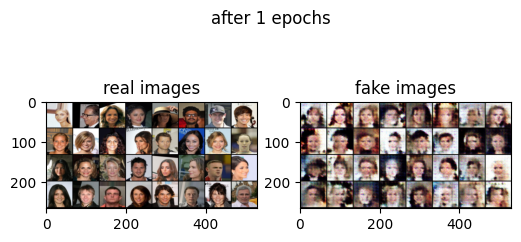

epoch:2/10 iteration:0/162079 Loss C :-4.517216682434082 -- Loss G :71.82405090332031
epoch:2/10 iteration:100/162079 Loss C :-3.876466989517212 -- Loss G :73.00743103027344
epoch:2/10 iteration:200/162079 Loss C :-3.3371806144714355 -- Loss G :73.05624389648438
epoch:2/10 iteration:300/162079 Loss C :-2.517404556274414 -- Loss G :75.84861755371094
epoch:2/10 iteration:400/162079 Loss C :-4.2829060554504395 -- Loss G :71.87637329101562
epoch:2/10 iteration:500/162079 Loss C :-4.28550910949707 -- Loss G :74.11135864257812
epoch:2/10 iteration:600/162079 Loss C :-3.8653998374938965 -- Loss G :73.10037231445312
epoch:2/10 iteration:700/162079 Loss C :-3.421449899673462 -- Loss G :72.3099136352539
epoch:2/10 iteration:800/162079 Loss C :-3.8858275413513184 -- Loss G :71.74668884277344
epoch:2/10 iteration:900/162079 Loss C :-3.899970054626465 -- Loss G :78.5472183227539
epoch:2/10 iteration:1000/162079 Loss C :-3.166050672531128 -- Loss G :78.75833892822266
epoch:2/10 iteration:1100/162079

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

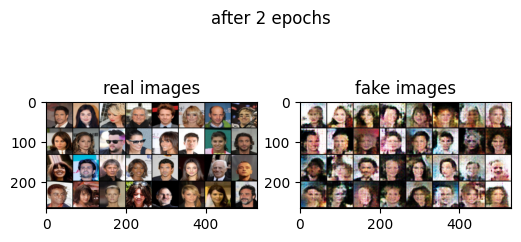

epoch:3/10 iteration:0/162079 Loss C :-3.6657278537750244 -- Loss G :82.51991271972656
epoch:3/10 iteration:100/162079 Loss C :-3.7304577827453613 -- Loss G :78.91886901855469
epoch:3/10 iteration:200/162079 Loss C :-4.838922023773193 -- Loss G :82.45342254638672
epoch:3/10 iteration:300/162079 Loss C :-3.52884578704834 -- Loss G :81.40359497070312
epoch:3/10 iteration:400/162079 Loss C :-2.6480116844177246 -- Loss G :80.19136810302734
epoch:3/10 iteration:500/162079 Loss C :-3.2318484783172607 -- Loss G :84.20227813720703
epoch:3/10 iteration:600/162079 Loss C :-3.072514295578003 -- Loss G :82.77515411376953
epoch:3/10 iteration:700/162079 Loss C :-3.174797773361206 -- Loss G :83.40685272216797
epoch:3/10 iteration:800/162079 Loss C :-3.0859928131103516 -- Loss G :82.03353118896484
epoch:3/10 iteration:900/162079 Loss C :-3.1103811264038086 -- Loss G :86.75585174560547
epoch:3/10 iteration:1000/162079 Loss C :-2.3417084217071533 -- Loss G :86.99765014648438
epoch:3/10 iteration:1100/1

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

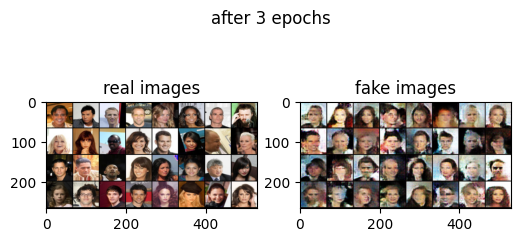

epoch:4/10 iteration:0/162079 Loss C :-2.3368709087371826 -- Loss G :87.01627349853516
epoch:4/10 iteration:100/162079 Loss C :-3.859707832336426 -- Loss G :85.51634979248047
epoch:4/10 iteration:200/162079 Loss C :-2.9987831115722656 -- Loss G :91.48448944091797
epoch:4/10 iteration:300/162079 Loss C :-3.469735622406006 -- Loss G :89.78343200683594
epoch:4/10 iteration:400/162079 Loss C :-3.4781131744384766 -- Loss G :91.00666046142578
epoch:4/10 iteration:500/162079 Loss C :-3.0555949211120605 -- Loss G :93.85070037841797
epoch:4/10 iteration:600/162079 Loss C :-3.3939497470855713 -- Loss G :93.7148208618164
epoch:4/10 iteration:700/162079 Loss C :-4.239831447601318 -- Loss G :96.21223449707031
epoch:4/10 iteration:800/162079 Loss C :-4.081524848937988 -- Loss G :91.06072235107422
epoch:4/10 iteration:900/162079 Loss C :-3.144840717315674 -- Loss G :97.98435974121094
epoch:4/10 iteration:1000/162079 Loss C :-2.5809924602508545 -- Loss G :96.48779296875
epoch:4/10 iteration:1100/16207

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

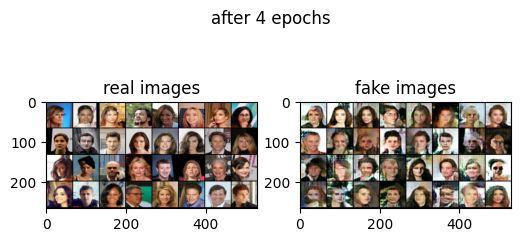

epoch:5/10 iteration:0/162079 Loss C :-1.508832573890686 -- Loss G :97.5008544921875
epoch:5/10 iteration:100/162079 Loss C :-2.9927163124084473 -- Loss G :94.0867919921875
epoch:5/10 iteration:200/162079 Loss C :-2.49568772315979 -- Loss G :96.80863952636719
epoch:5/10 iteration:300/162079 Loss C :-4.019196510314941 -- Loss G :91.74461364746094
epoch:5/10 iteration:400/162079 Loss C :-2.564905881881714 -- Loss G :98.96525573730469
epoch:5/10 iteration:500/162079 Loss C :-3.1832151412963867 -- Loss G :97.04106140136719
epoch:5/10 iteration:600/162079 Loss C :-2.8811731338500977 -- Loss G :101.79341125488281
epoch:5/10 iteration:700/162079 Loss C :-3.5926756858825684 -- Loss G :95.81881713867188
epoch:5/10 iteration:800/162079 Loss C :-2.9069602489471436 -- Loss G :102.00536346435547
epoch:5/10 iteration:900/162079 Loss C :-2.5480058193206787 -- Loss G :102.33206176757812
epoch:5/10 iteration:1000/162079 Loss C :-2.6870181560516357 -- Loss G :98.7795181274414
epoch:5/10 iteration:1100/1

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

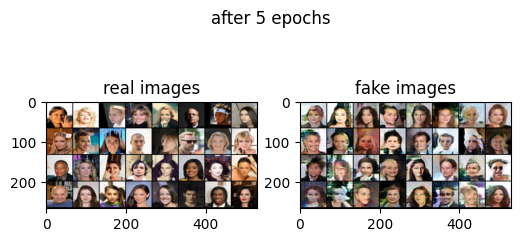

epoch:6/10 iteration:0/162079 Loss C :-3.520411491394043 -- Loss G :97.12165832519531
epoch:6/10 iteration:100/162079 Loss C :-3.639577865600586 -- Loss G :109.56033325195312
epoch:6/10 iteration:200/162079 Loss C :-2.955784559249878 -- Loss G :108.7041244506836
epoch:6/10 iteration:300/162079 Loss C :-2.309091806411743 -- Loss G :98.25513458251953
epoch:6/10 iteration:400/162079 Loss C :-1.515418291091919 -- Loss G :103.74891662597656
epoch:6/10 iteration:500/162079 Loss C :-3.1831369400024414 -- Loss G :111.58467864990234
epoch:6/10 iteration:600/162079 Loss C :-2.817448139190674 -- Loss G :101.09814453125
epoch:6/10 iteration:700/162079 Loss C :-3.2296509742736816 -- Loss G :106.18464660644531
epoch:6/10 iteration:800/162079 Loss C :-2.704754590988159 -- Loss G :105.156982421875
epoch:6/10 iteration:900/162079 Loss C :-2.5839788913726807 -- Loss G :105.82405090332031
epoch:6/10 iteration:1000/162079 Loss C :-2.414915084838867 -- Loss G :105.05274200439453
epoch:6/10 iteration:1100/1

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

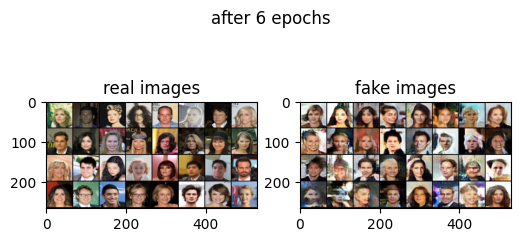

epoch:7/10 iteration:0/162079 Loss C :-3.2583882808685303 -- Loss G :107.7559585571289
epoch:7/10 iteration:100/162079 Loss C :-2.7265827655792236 -- Loss G :104.9061508178711
epoch:7/10 iteration:200/162079 Loss C :-2.0790112018585205 -- Loss G :105.09856414794922
epoch:7/10 iteration:300/162079 Loss C :-2.2262468338012695 -- Loss G :104.30340576171875
epoch:7/10 iteration:400/162079 Loss C :-3.1797306537628174 -- Loss G :111.97869110107422
epoch:7/10 iteration:500/162079 Loss C :-1.6029127836227417 -- Loss G :108.16853332519531
epoch:7/10 iteration:600/162079 Loss C :-2.8997952938079834 -- Loss G :110.62248229980469
epoch:7/10 iteration:700/162079 Loss C :-1.7235310077667236 -- Loss G :113.20637512207031
epoch:7/10 iteration:800/162079 Loss C :-1.4970109462738037 -- Loss G :110.92951965332031
epoch:7/10 iteration:900/162079 Loss C :-2.581860065460205 -- Loss G :113.99227905273438
epoch:7/10 iteration:1000/162079 Loss C :-2.617608070373535 -- Loss G :106.23431396484375
epoch:7/10 iter

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

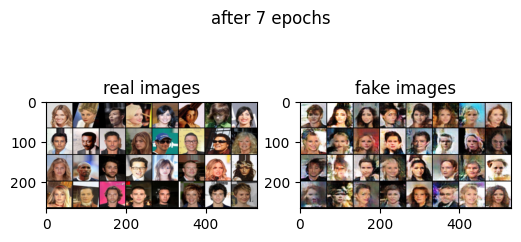

epoch:8/10 iteration:0/162079 Loss C :-3.7179207801818848 -- Loss G :118.703369140625
epoch:8/10 iteration:100/162079 Loss C :-2.520944118499756 -- Loss G :111.5566635131836
epoch:8/10 iteration:200/162079 Loss C :-1.6854195594787598 -- Loss G :106.39065551757812
epoch:8/10 iteration:300/162079 Loss C :-2.6335396766662598 -- Loss G :107.50972747802734
epoch:8/10 iteration:400/162079 Loss C :-2.4045069217681885 -- Loss G :113.59744262695312
epoch:8/10 iteration:500/162079 Loss C :-1.3668274879455566 -- Loss G :109.82111358642578
epoch:8/10 iteration:600/162079 Loss C :-2.2774546146392822 -- Loss G :111.911865234375
epoch:8/10 iteration:700/162079 Loss C :-2.222172260284424 -- Loss G :111.46620178222656
epoch:8/10 iteration:800/162079 Loss C :-2.9470362663269043 -- Loss G :118.13860321044922
epoch:8/10 iteration:900/162079 Loss C :-3.592203140258789 -- Loss G :107.07893371582031
epoch:8/10 iteration:1000/162079 Loss C :-1.7711423635482788 -- Loss G :107.79708862304688
epoch:8/10 iteratio

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

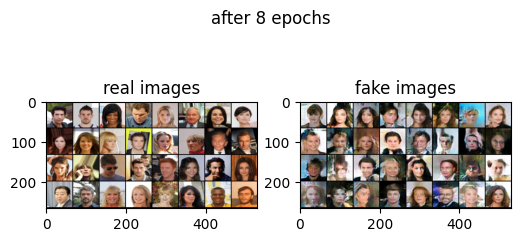

epoch:9/10 iteration:0/162079 Loss C :-2.117332935333252 -- Loss G :119.43069458007812
epoch:9/10 iteration:100/162079 Loss C :-1.7119208574295044 -- Loss G :114.00102233886719
epoch:9/10 iteration:200/162079 Loss C :-2.6892735958099365 -- Loss G :111.21514892578125
epoch:9/10 iteration:300/162079 Loss C :-1.3510682582855225 -- Loss G :114.195068359375


KeyboardInterrupt: 

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

<Figure size 1300x400 with 0 Axes>

In [31]:
C = Critic(img_channels, hidden_C).to(device)
G = Generator(noise_channels, img_channels, hidden_G).to(device)

# C=C.apply(init_weights)
# G=G.apply(init_weights)

wandb.watch(G, log='all', log_freq=10)
wandb.watch(C, log='all', log_freq=10)

opt_C = torch.optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

gen_repeats = 1
crit_repeats = 3

noise_for_generate = torch.randn(batch_size, noise_channels, 1, 1).to(device)

losses_C = []
losses_G = []

for epoch in range(1, epochs+1):
    loss_C_epoch = []
    loss_G_epoch = []

    for idx, x in enumerate(train_dataloader):
        C.train()
        G.train()

        x = x.to(device)
        x_len = x.shape[0]

        # 训练判别器

        loss_C_iter = 0
        for _ in range(crit_repeats):
            opt_C.zero_grad()
            z = torch.randn(x_len, noise_channels, 1, 1).to(device)

            real_imgs = x
            fake_imgs = G(z).detach()
            #print(fake_imgs.shape,real_imgs.shape)
            real_C_out = C(real_imgs)
            fake_C_out = C(fake_imgs)
            
            #随机创建混合图片，并计算梯度
            epsilon = torch.rand(
                len(x), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(C, real_imgs, fake_imgs.detach(), epsilon)
            #计算梯度惩罚
            gp = gradient_penalty(gradient)
            loss_C = get_crit_loss(fake_C_out, real_C_out, gp, c_lambda=10)

            loss_C.backward()
            opt_C.step()

            loss_C_iter += loss_C.item()/crit_repeats

        # 训练生成器
        loss_G_iter = 0
        for _ in range(gen_repeats):
            opt_G.zero_grad()
            z = torch.randn(x_len, noise_channels, 1, 1).to(device)
            fake_C_out = C(G(z))
            loss_G = get_gen_loss(fake_C_out)
            loss_G.backward()
            opt_G.step()

            loss_G_iter += loss_G.item()/gen_repeats

        # Return current state
        if idx % 100 == 0:
            print(
                f'epoch:{epoch}/{epochs} iteration:{idx}/{len(train_dataset)} Loss C :{loss_C} -- Loss G :{loss_G}')
            artifact_G = wandb.Artifact("Generator_artifact", type='model', metadata={
                                        'epoch': epoch}, description=f"after {epoch} epochs")
            artifact_C = wandb.Artifact("Critic_artifact", type='model', metadata={
                                        'epoch': epoch}, description=f"after {epoch} epochs")

            save_model_as_checkpoint_wfdb(epoch=epoch, model=G, optimizer=opt_G, loss=loss_G,
                                          path='latest_model/checkpoint_G.pth', run=run, artifact=artifact_G)
            save_model_as_checkpoint_wfdb(epoch=epoch, model=C, optimizer=opt_C, loss=loss_C,
                                          path='latest_model/checkpoint_C.pth', run=run, artifact=artifact_C)

            with torch.no_grad():
                G.eval()
                generated = G(noise_for_generate).detach()
                img_grid_real = torchvision.utils.make_grid(
                    x[:32]*0.5+0.5).permute(1, 2, 0).squeeze().cpu()
                img_grid_fake = torchvision.utils.make_grid(
                    generated[:32]*0.5+0.5).permute(1, 2, 0).squeeze().cpu()

                plt.figure(figsize=(13, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(img_grid_real)
                plt.title('real images')
                plt.subplot(1, 2, 2)
                plt.imshow(img_grid_fake)
                plt.title('fake images')
                plt.suptitle(f'after {epoch} epochs')
                # wandb.log({"img": [wandb.Image(plt, caption=f"(after {epoch} epochs)")]})
                # wandb.log({f'{name} : output images': plt, 'epoch': epoch})
                wandb.log(
                    {f"{name} : output images : (after {epoch} epochs, idx : {idx})": plt})
                plt.clf()

        if idx == 2500:
            break

        loss_G_epoch.append(loss_G_iter)
        loss_C_epoch.append(loss_C_iter)
    losses_G.append(np.mean(loss_G_epoch))
    losses_C.append(np.mean(loss_C_epoch))

    # wandb.log({'losses_G': np.mean(loss_G_epoch), 'epoch': epoch})
    # wandb.log({'losses_C': np.mean(loss_C_epoch), 'epoch': epoch})

    # plot images for a epoch
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_grid_real)
    plt.title('real images')
    plt.subplot(1, 2, 2)
    plt.imshow(img_grid_fake)
    plt.title('fake images')
    plt.suptitle(f'after {epoch} epochs')
    plt.show()

    # plot losses for a epoch
    plt.figure()
    plt.plot(losses_G, label='Gen Loss')
    plt.plot(losses_C, label='Critic Loss')
    plt.title(f'after {epoch} epochs')
    wandb.log({f"losses": plt})
    plt.show()

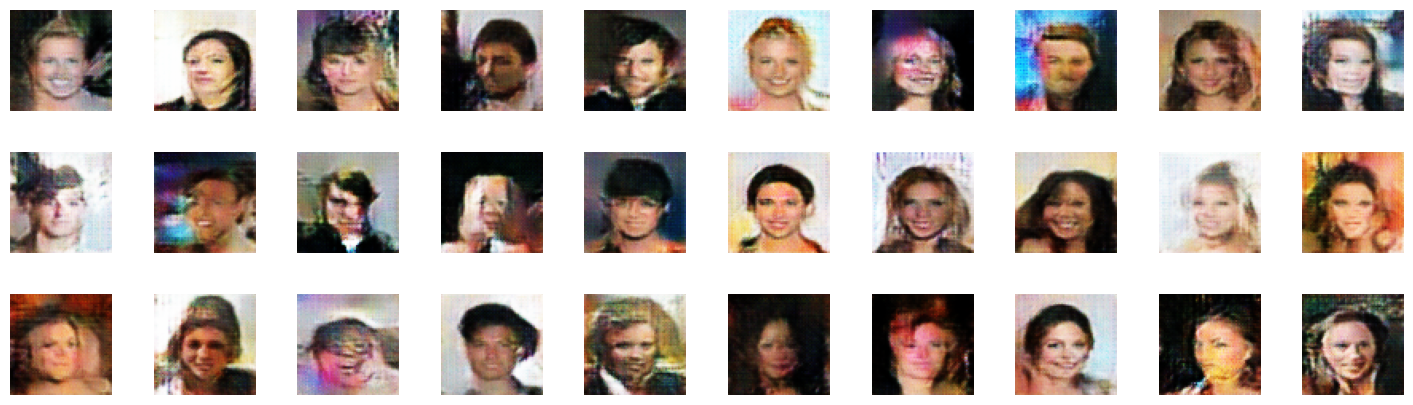

In [42]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,noise_channels,1,1))

reconst =G(torch.from_numpy(znew).float().cuda())
reconst=(reconst*0.5+0.5)
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    img = reconst[i].squeeze()
    ax = fig.add_subplot(3,10, i+1)
    ax.imshow(img.detach().cpu().numpy().transpose((1,2,0)))
    ax.axis('off')

plt.show()
fig.savefig('1.png')